<a href="https://colab.research.google.com/github/JuanCervigon/master2025/blob/main/Regresion_Poisson_Bicis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Regresión de Poisson

La regresión de Poisson se suele utliizar para predecir el número de eventos en un periodo de tiempo.

En este caso vamos a analizar la variable dependiente "número diario de bicicletas alquiladas en Washington". En este caso el número de eventos es el número de bicilcetas y el periodo de tioempo es durante un día.

El modelo de regresión de Poisson considera que el numero de bicicletas alquiladas cada día es una variable aleatoria de Poisson de parámetro lambda igual al número e elevado a una combinación lineal de las variables explicativas

$y_i∼Poisson(λ_i)$ donde $λ_i=e^{x_iβ}$


Los datos se han obtenido de:
Fanaee-T, Hadi, and Gama, Joao, "Event labeling combining ensemble detectors and background knowledge", Progress in Artificial Intelligence (2013): pp. 1-15, Springer Berlin Heidelberg

El cuaderno se ha estructurado en los siguientes apartados:

* Leer y visualizar los datos
* Recodificar la variable "wheathersit" para convertirla en variables dummy
* Especificar, ajustar y valorar el modelo


In [ ]:
# Importar las librerías
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt



# Leer y visualizar los datos

Hacer "drag and drop" con el fichero de datos. Descargar el fichero en el ordenador local y después arrastrarlo para copiarlo en Google Colab

Cada observación o fila del data-set es un día. El data-set contiene 731 filas que se corresponde con 731 días. De cada día se ha recogido los valores de diferentes variables relativas tipo de día (dia laborable, fin de semana, festivo), al tiempo (temperatura, humedad, viento, etc). Asimismo se recogen el número de bicicletas que se han alquilado distinguiendo entre las alquiladas por usuarios "casual", es decir, usarios ocasionales y usuarios "registered", es decir, usuario registrados.

- instant: record index
- dteday : date
- season : season (1:springer, 2:summer, 3:fall, 4:winter)
- yr : year (0: 2011, 1:2012)
- mnth : month ( 1 to 12)
- hr : hour (0 to 23)
- holiday : weather day is holiday or not
- weekday : day of the week
- workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
- weathersit :
 - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
 - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
 - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
 - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
- temp : Normalized temperature in Celsius. The values are divided to 41 (max)
- atemp: Normalized feeling temperature in Celsius. The values are divided to 50 (max)
- hum: Normalized humidity. The values are divided to 100 (max)
- windspeed: Normalized wind speed. The values are divided to 67 (max)
- casual: count of casual users
- registered: count of registered users
- cnt: count of total rental bikes including both casual and registered



In [ ]:
# Leer y visualizar los datos

ruta="/content/Bicicletas.xlsx"
df=pd.read_excel(ruta)
df

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
726,727,2012-12-27,1,1,12,0,4,1,2,0.254167,0.226642,0.652917,0.350133,247,1867,2114
727,728,2012-12-28,1,1,12,0,5,1,2,0.253333,0.255046,0.590000,0.155471,644,2451,3095
728,729,2012-12-29,1,1,12,0,6,0,2,0.253333,0.242400,0.752917,0.124383,159,1182,1341
729,730,2012-12-30,1,1,12,0,0,0,1,0.255833,0.231700,0.483333,0.350754,364,1432,1796


In [ ]:
# visualizar los tipos de datos que hemos subido
df.dtypes

instant                int64
dteday        datetime64[ns]
season                 int64
yr                     int64
mnth                   int64
holiday                int64
weekday                int64
workingday             int64
weathersit             int64
temp                 float64
atemp                float64
hum                  float64
windspeed            float64
casual                 int64
registered             int64
cnt                    int64
dtype: object

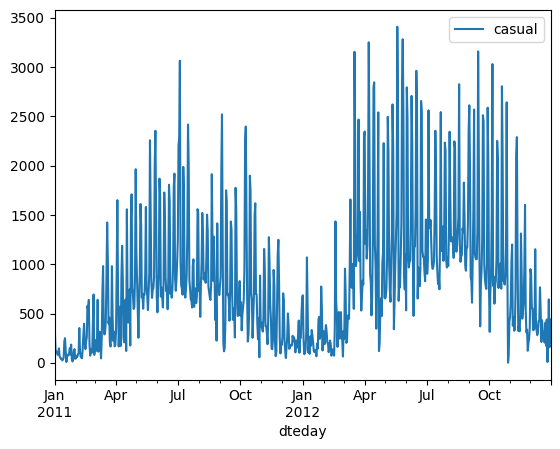

In [ ]:
# Visualizar la variable dependiente "casual"
df.plot(x="dteday", y="casual");


# Modificar y seleccionar variables

Vamos a considerar como variable dependiente la variable 'casual' que es el número de bicicletas alquiladas por usuarios no registrados.

Como variables independientes utilizaremos las variables

* workingday. Valor=1 para los días laborables y 0 para los días festivos
* Regular. Nueva variable dummy, valor=1 días con poca lluvia o poca nieve, valor=0 resto días
* Malo. Nueva variable dummy, valor=1 días con mucha lluvia o mucha nieve, valor=0 resto días
* atem. Sensación térmica.Valor normalizado
* hum. Humedad relativa. Valor normalizado
* windspeed. Velocidad del viento. Valor normalizado


Las variables nuevas Regular y Malo las obtenemos a partir de la variable "weathersit". Para ello primero se realiza los siguiente:

* Crear la variable TipoDia={Bueno si weathersit=1 o 2, Regular si weathersit=3, Malo si weathersit=4}
* Crear las variables dummy "Bueno", "Regular" y "Malo" según el valor de la variable TipoDia
* Descartamos la variable "Bueno" para evitar la multicolinealidad. Por lo tanto se entiende que "Bueno"=1 cuando las variables "Regular" y "Malo" toman el valor=0



In [ ]:
# Hacer un listado de las columnas
df.columns

Index(['instant', 'dteday', 'season', 'yr', 'mnth', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
       'casual', 'registered', 'cnt'],
      dtype='object')

In [ ]:
# Sustituir los valores numéricos de la variable weathrsit
# por la categoría

df.loc[df['weathersit'] == 1, 'weathersit'] = 'bueno'
df.loc[df['weathersit'] == 2, 'weathersit'] = 'regular'
df.loc[df['weathersit'] == 3, 'weathersit'] = 'malo'
df.loc[df['weathersit'] == 4, 'weathersit'] = 'malo'


In [ ]:
df

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,regular,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,regular,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,bueno,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,bueno,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,bueno,0.226957,0.229270,0.436957,0.186900,82,1518,1600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
726,727,2012-12-27,1,1,12,0,4,1,regular,0.254167,0.226642,0.652917,0.350133,247,1867,2114
727,728,2012-12-28,1,1,12,0,5,1,regular,0.253333,0.255046,0.590000,0.155471,644,2451,3095
728,729,2012-12-29,1,1,12,0,6,0,regular,0.253333,0.242400,0.752917,0.124383,159,1182,1341
729,730,2012-12-30,1,1,12,0,0,0,bueno,0.255833,0.231700,0.483333,0.350754,364,1432,1796


In [ ]:
# Crear las nuevas variable dummy (por defecto la primera no la considera)
data = pd.get_dummies(df, drop_first=True)
data.columns

Index(['instant', 'dteday', 'season', 'yr', 'mnth', 'holiday', 'weekday',
       'workingday', 'temp', 'atemp', 'hum', 'windspeed', 'casual',
       'registered', 'cnt', 'weathersit_malo', 'weathersit_regular'],
      dtype='object')

In [ ]:
# Seleccionar las variables independientes y la variable dependiente
x=data[[ 'workingday', 'atemp', 'hum', 'windspeed',
       'weathersit_malo', 'weathersit_regular']]
y=data['casual']

In [ ]:
# Añadir un vector de unos a la izquierda del dataset
x_1=sm.add_constant(x)

# Especificar el modelo, hacer el ajuste
especifica=sm.GLM(y, x_1, family=sm.families.Poisson())
#especifica=sm.GLM(y, x, family=sm.families.Poisson(sm.families.links.log()))
ajusta=especifica.fit()
print(ajusta.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 casual   No. Observations:                  731
Model:                            GLM   Df Residuals:                      724
Model Family:                 Poisson   Df Model:                            6
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -66100.
Date:                Sat, 16 Mar 2024   Deviance:                   1.2622e+05
Time:                        10:30:19   Pearson chi2:                 1.31e+05
No. Iterations:                     6   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  6.3946      0

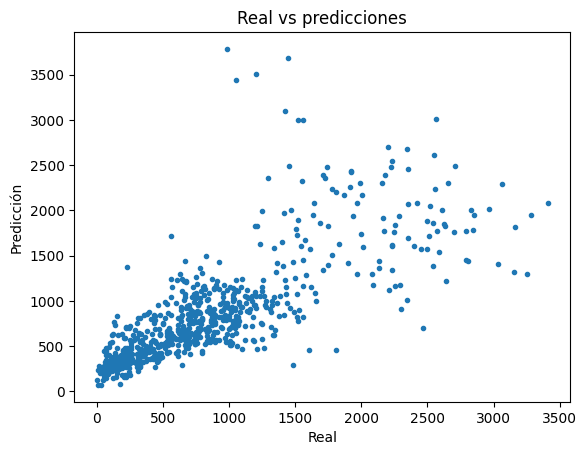

In [ ]:
# Hacer un gráfico de las observaciones reales frente a las predicciones

y_hat=ajusta.predict(x_1)
plt.scatter(y, y_hat, marker='.')
#plt.scatter(y,y_hat)
plt.xlabel('Real')
plt.ylabel('Predicción')
plt.title('Real vs predicciones')
plt.show();